# ASTH-19 Group Project
This notebook is for the Astro-19 group project.

Authors: Jack O'Brien, Leo Constantine, Verónica Sánchez M. Thomas Liao

In [3]:
# In this cell, we include libraries
import astropy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy
import math

Now, we're parsing the file. It will be returned as two lists containing data from each of the columns.

In [4]:
# set filepath variable to be used everywhere - makes it easier to change this around as needed
FILE_PATH_DEF = "dataset.txt"

In [5]:
data_txt = open(FILE_PATH_DEF, 'r')

In [6]:
def ParseFile(_Filename:str = "dataset.txt"):
    
#     # Firstly, read it into a list line by line
#     Lines:list = []
#     with open(_Filename, "r") as F:
#         for Line in F:
#             Lines.append(Line)
    
#     # Now, remove those that start with a '#'
#     FilteredLines:list = []
#     for Line in Lines:
#         if "#" not in Line:
#             FilteredLines.append(Line)
            
#     # Now parse into arrays
#     Column0:list = []
#     Column1:list = []
#     Column2:list = []
#     for Line in FilteredLines:
#         Column0.append(Line[:3].replace(" ", ""))
#         Column1.append(Line[4:9])
#         Column2.append(Line[10:].strip("\n"))
           
    data_txt = open(_Filename, "r")
    
    Column0 = []
    Column1 = []
    Column2 = []
    for line in data_txt.readlines():
        cols = line.split()
        Column0.append(float(cols[0]))
        Column1.append(str(cols[1]))
        Column2.append(float(cols[2]))
    
    data_txt.close()
    
    # Return arrays
    return Column0, Column1, Column2


Now, we are going to parse the times in terms of seconds, then sort it based on time.

In [7]:
def SortTimes(_Days:list, _Times:list, _Height:list):
    
    # Firstly, we enumerate times, and convert from hh:mm to seconds
    TimeSeconds:list = []
    for i in range(len(_Times)):
        Day = int(_Days[i]) - 1 # days start at 1, not 0
        Hours = int(_Times[i].split(":")[0])
        Minutes = int(_Times[i].split(":")[1])
        Seconds = (Day * 3600 * 24) + (Hours * 3600) + (Minutes * 60)
        TimeSeconds.append(Seconds)
        
    # Build Tuple For Sorting
    TimePairs:list = []
    for i in range(len(_Height)):
        CurrentTime_s = TimeSeconds[i]
        Height = _Height[i]
        TimePairs.append((CurrentTime_s, float(Height)))
    
    # Now Sort it
    TimePairs = sorted(TimePairs)
    
    # Now resplit it
    XValues = []
    YValues = []
    for Pair in TimePairs:
        XValues.append(Pair[0]/(3600))

        YValues.append(Pair[1])
    
    
    
    return XValues, YValues

Now, we generate the plots for the tidal wave, showing the data (as a function).

In [80]:
def PlotTidalWave(_Timestamps:list, _Waveheights:list):
    plt.figure(figsize=(10, 6))
    plt.plot(_Timestamps, _Waveheights)
    plt.xlabel("Time (hours)")
    plt.ylabel("Tide height (meters)")
    plt.title("Tidal Wave")

Next, we define a model that we attempt to curve fit below, this was painful to get right.

In [81]:
def Model(x, a, b, c, d, e, f, g, h, i):
    return (np.cos(a*x + h)*b + f) * (np.sin(c*x + i)*d + g) + e

Okay, this sucked. I couldn't get the optimizer to work properly, so I tried to use a brute force approach to get this to work, which kinda worked. Naturally it was slow, so in another python notebook file, multithreading was used to increase the speed at which we brute-forced our approach. That's what the following two *unused* functions do.

In [82]:
def OptimizeModel(_XValues:list, _YValues:list, _Function:object):
    return scipy.optimize.curve_fit(_Function, _XValues, _YValues, p0=[0.017, 6, 0.221, 5, 1, 1, 1, 1, 1], maxfev=100000)

In [83]:
def PerformCurveFit(_XValues:list, _YValues:list):
    
    _XValues = np.asarray(_XValues)
    _YValues = np.asarray(_YValues)
    
    
        
    NumSamples:int = 4000
    DetailedXValues:list = np.linspace(0, np.max(_XValues), NumSamples)
    DetailedYValues:list = np.interp(DetailedXValues, _XValues, _YValues)
    
    y_err = np.full_like(DetailedYValues, 0.25)
    
    BestParams:list = []
    BestError:float = 9999999
    for b in range(-5, 5):
        for d in range(-5, 5):
            for a in range(0, 2):


                OptimizedParameters, ErrorValues = scipy.optimize.curve_fit(Model, DetailedXValues, DetailedYValues, p0=[a/20, 8, 0.221, 10, 1, 1, 1,  b/10,  d/10], sigma=y_err, maxfev=100000)

                ErrorArray = np.sqrt(np.diag(ErrorValues))
                AvgError = np.average(ErrorArray)

                if (AvgError < BestError):
                    print(f"New Best Err: {AvgError}")
                    BestError = AvgError
                    BestParams = OptimizedParameters

    
    print(BestParams)
    plt.plot(DetailedXValues, DetailedYValues)
    plt.plot(DetailedXValues, Model(DetailedXValues, *BestParams.tolist()))

Now, we have the rest of the plotting functions used to make the fancy graphs and stuff.

In [84]:
def PlotModelFit(_XValues:list, _YValues:list, DetailedXValues:list, DetailedYValues:list, OptimizedParameters:object):
    # Plot the data and model
    plt.figure(figsize=(10, 6))
    plt.errorbar(_XValues, _YValues, yerr=0.25, fmt='o', label='Data with error bars')
    plt.plot(DetailedXValues, DetailedYValues, label='Measured Data', color='blue')
    plt.plot(DetailedXValues, Model(DetailedXValues, *OptimizedParameters.tolist()), label='Model Fit', color='red')
    
    
    # Plot Model Fit Information
    plt.xlabel('Time (hours)')
    plt.ylabel('Tide Height (feet)')
    plt.legend()
    plt.title('Tidal Data and Model Fit')
    plt.savefig('tidal_data_and_model_fit.pdf')
    plt.show()
    

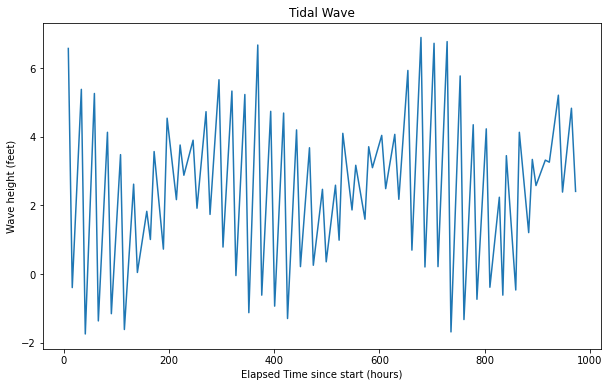

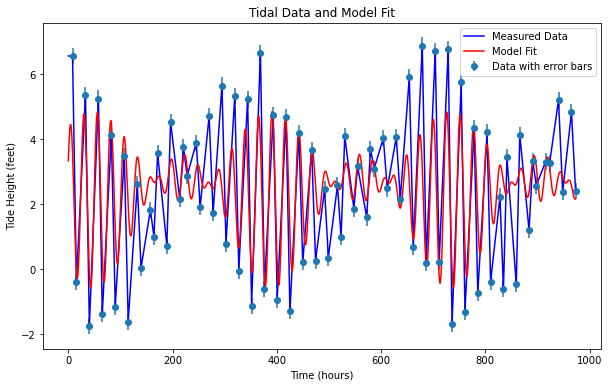

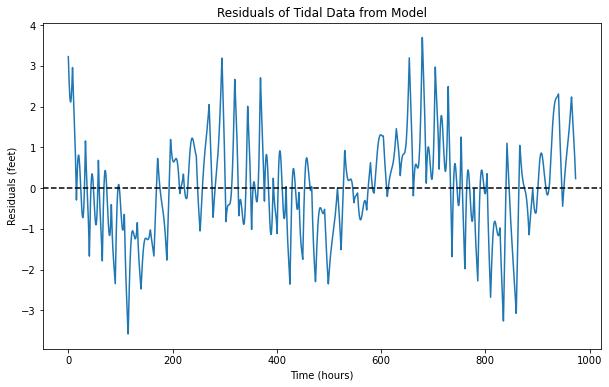

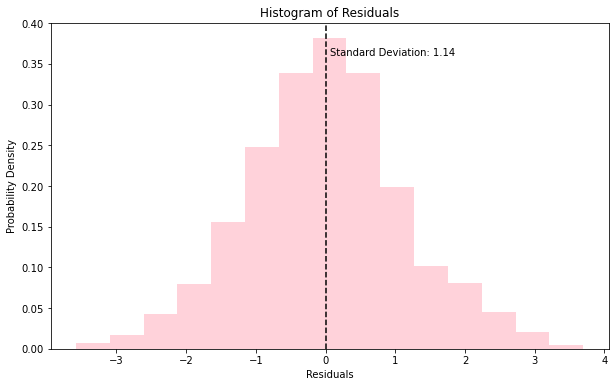

Deviation of tsunami (2ft) from normal tides: 1.76 standard deviations


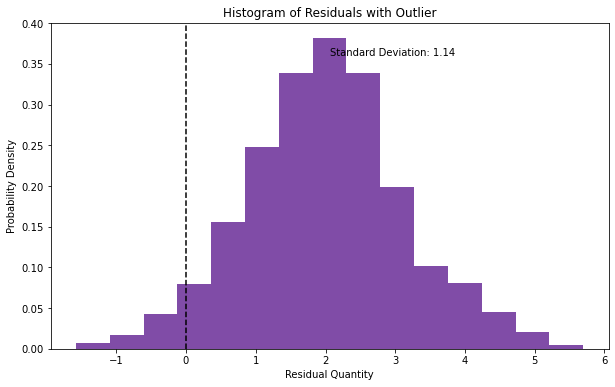

In [86]:
def Main():
    Days, TimesRaw, WaveHeights = ParseFile(FILE_PATH_DEF)
    Timestamps, WaveHeights = SortTimes(Days, TimesRaw, WaveHeights)

    
    
    # Perform Curve Fit Optimization On Our Model, With Pretuned Initial Guess Parameters
    _XValues = np.asarray(Timestamps)
    _YValues = np.asarray(WaveHeights)
    NumSamples:int = 4000
    DetailedXValues:list = np.linspace(0, np.max(_XValues), NumSamples)
    DetailedYValues:list = np.interp(DetailedXValues, _XValues, _YValues)
    y_err = np.full_like(DetailedYValues, 0.25)
    
    # would reccomend multithreading for making your initial guesses way faster (if you're lazy like me anyway)
    OptimizedParameters, ErrorValues = scipy.optimize.curve_fit(Model, DetailedXValues, DetailedYValues, p0=[0.25, 0.5, 0.017, 1.8, 2, 1, 1,  0,  2.2], sigma=y_err, maxfev=100000)
    
    ErrorArray = np.sqrt(np.diag(ErrorValues))
    AvgError = np.average(ErrorArray)

    
    ## -- Generate Graphs -- ##
    PlotTidalWave(Timestamps, WaveHeights)
    PlotModelFit(_XValues, _YValues, DetailedXValues, DetailedYValues, OptimizedParameters)
    
    
    
    
    
    # Plot Model Residual Information
    residuals = DetailedYValues -  Model(DetailedXValues, *OptimizedParameters.tolist())
    plt.figure(figsize=(10, 6))
    plt.plot(DetailedXValues, residuals)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Time (hours)')
    plt.ylabel('Residuals (feet)')
    plt.title('Residuals of Tidal Data from Model')
    plt.savefig('tidal_residuals.pdf')
    plt.show()
    
    
    # Calculate std deviation of residuals
    std_dev_residuals = np.std(residuals)
    
    
    # Plot histogram of residuals
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(residuals, bins=15, density=True, alpha=0.7, color='pink', label='Residuals')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Probability Density')
    plt.title('Histogram of Residuals')
    plt.text(0.5, 0.9, f'Standard Deviation: {std_dev_residuals:.2f}', transform=plt.gca().transAxes)
    plt.savefig('histogram_residuals.pdf')
    plt.show()
    
    
    ## Calculate Std Deviation with Outliers stripped
    
    # Calculate the deviation of the tsunami (2ft) in terms of standard deviations
    tsunami_deviation = 2 / std_dev_residuals
    print(f"Deviation of tsunami (2ft) from normal tides: {tsunami_deviation:.2f} standard deviations")
    
    # Add the outlier to the data and replot histogram
    outlier = 2.0  # 2ft outlier
    tides_with_outlier = DetailedYValues + [outlier]
    
    # Ensure tides_with_outlier has the same length as hours
    if len(tides_with_outlier) != len(DetailedXValues):
        tides_with_outlier = tides_with_outlier[:-1]
        
    
    # Calculate new residuals
    residuals_outlier = tides_with_outlier - Model(DetailedXValues, *OptimizedParameters.tolist())

    # Plot histogram with outlier
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(residuals_outlier, bins=15, density=True, alpha=0.7, color='indigo', label='Residuals with Outlier')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Residual Quantity')
    plt.ylabel('Probability Density')
    plt.title('Histogram of Residuals with Outlier')
    plt.text(0.5, 0.9, f'Standard Deviation: {std_dev_residuals:.2f}', transform=plt.gca().transAxes)
    plt.savefig('histogram_residuals_with_outlier.pdf')
    plt.show()

    
if __name__ == "__main__":
    Main()